In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from datetime import datetime, timedelta
import xgboost as xgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from matplotlib import pyplot
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV as GridSearch

ImportError: No module named xgboost

In [ ]:
#apariciones primeros 3 dias
appearances_train = pd.read_csv("appearances_first_3_days.csv", header=None, names=["device_id", "date", "seconds_until_next_appearence"])

In [ ]:
#apariciones segundos 3 dias
appearances_test =  pd.read_csv("appearances_second_3_days.csv", header=None, names=["device_id", "date", "seconds_until_next_appearence"])

In [2]:
#convertions_train = pd.read_csv("auctions_deltas_to_convertion_train.csv",header=None, names=["device_id", "date", "seconds_until_convertion"])

In [3]:
#convertions_test = pd.read_csv("auctions_deltas_to_convertion_test.csv",header=None, names=["device_id", "date", "seconds_until_convertion"])

In [4]:
#ids a predecir en ambos problemas
ids_to_predict = pd.read_csv("target_competencia_ids.csv")

IOError: [Errno 2] File target_competencia_ids.csv does not exist: 'target_competencia_ids.csv'

In [9]:
ids_to_predict = ids_to_predict[["ref_hash"]]

In [10]:
appearances_train["date"] = pd.to_datetime(appearances_train["date"])

In [11]:
appearances_test["date"] = pd.to_datetime(appearances_test["date"])

In [12]:
#convertions_test["date"] = pd.to_datetime(convertions_test["date"])

In [13]:
#convertions_train["date"] = pd.to_datetime(convertions_train["date"])

In [14]:
events = pd.read_csv("events.csv")

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (13,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [15]:
#appearances_test["is_weekend"] = appearances_test.apply(lambda row: row["date"].weekday()>4 , axis=1)

In [16]:
#convertions_test["is_weekend"] = convertions_test.apply(lambda row: row["date"].weekday()>4 , axis=1)

In [17]:
#convertions_train["is_weekend"] = convertions_train.apply(lambda row: row["date"].weekday()>4 , axis=1)

In [18]:
ids_to_predict_numbers = ids_to_predict.copy()

In [19]:
#paso refhash a int sacandole los _sc o _st
ids_to_predict_numbers["ref_hash"] = ids_to_predict_numbers["ref_hash"].apply(lambda string: int(string.split("_")[0]))

In [20]:
#borro duplicados
ids_to_predict_numbers = ids_to_predict_numbers.drop_duplicates()

In [21]:
#por enunciado la fecha de los ids a predecir tiene que ser esta LA MISMA PARA TODOS
#o sea hay que predecir los segundos a partir de esa fecha
ids_to_predict_numbers["date"] = datetime(2019, 5, 27, 0,0,0)

In [22]:
ids_to_predict_numbers.head()

,ref_hash,date
0,1000169251625791246,2019-05-27
2,1000395625957344683,2019-05-27
4,1003027494996471685,2019-05-27
6,1006670001679961544,2019-05-27
8,1007573308966476713,2019-05-27


In [23]:
#la copio en 2 dfs distintos para usar, uno para predecir el tiempo en reaparecer en auction
#y otro para predecir el tiempo en convertir/instalar

In [24]:
ids_to_predict_numbers_appearances = ids_to_predict_numbers.copy()

In [25]:
ids_to_predict_numbers_convertion = ids_to_predict_numbers.copy()

In [332]:
appearances_train.head()

,device_id,date,seconds_until_next_appearence
0,4172466725848941608,2019-04-18 06:27:50.996158,848.908411
1,4172466725848941608,2019-04-18 06:41:59.904569,28513.038578
2,4172466725848941608,2019-04-18 14:37:12.943147,199.094384
3,4172466725848941608,2019-04-18 14:40:32.037531,185.775504
4,4172466725848941608,2019-04-18 14:43:37.813035,255.313251


In [333]:
ids_to_predict_numbers_appearances.head()

,device_id,date
0,1000169251625791246,2019-05-27
2,1000395625957344683,2019-05-27
4,1003027494996471685,2019-05-27
6,1006670001679961544,2019-05-27
8,1007573308966476713,2019-05-27


In [334]:
#renombro columna para poder mergear por id
ids_to_predict_numbers_appearances = ids_to_predict_numbers_appearances.rename(columns={"ref_hash": "device_id"})

In [335]:
ids_to_predict_numbers_appearances.head()

,device_id,date
0,1000169251625791246,2019-05-27
2,1000395625957344683,2019-05-27
4,1003027494996471685,2019-05-27
6,1006670001679961544,2019-05-27
8,1007573308966476713,2019-05-27


In [336]:
#les agrego los features

In [337]:
#appearances_train["is_weekend"] = appearances_train["data"].apply(lambda date: date.weekday()>4)

In [338]:
#ids_to_predict_numbers_appearances["is_weekend"] = ids_to_predict_numbers_appearances["date"].apply(lambda date: date["date"].weekday()>4)

In [339]:
#voy a agregar feature de APP mas usada para cada ID
most_used_app = events.groupby("ref_hash")["application_id"].agg(lambda x: x.mode()).rename_axis("device_id").to_frame().reset_index()


In [340]:
#arreglo que algunos casos la app id mas usada es una lista. porque la funcion .mode() devolvio mas de un elemento
most_used_app["application_id"] = most_used_app["application_id"].apply(lambda x: x[0] if type(x) == np.ndarray else x)

In [341]:
#SE LO AGREGO A LOS 3 DFS , cosa que voy a hacer con todos los nuevos features
#porque train (primeros 3 dias) es para entrenar, test (segundos 3 dias) es para testear, y competition es
#para submitear 

In [342]:
df_train = appearances_train.merge(most_used_app, on="device_id", how="left")

In [343]:
df_test = appearances_test.merge(most_used_app, on="device_id", how="left")
df_competition = ids_to_predict_numbers_appearances.merge(most_used_app, on="device_id", how="left")

In [344]:
#renombro para dejar mas claro que el nombre del nuevo feature
df_train = df_train.rename({"application_id": "most_used_app"}, axis="columns")
df_test = df_test.rename({"application_id": "most_used_app"}, axis="columns")
df_competition = df_competition.rename({"application_id": "most_used_app"}, axis="columns")

In [345]:
#reemplazo los nan de most used app por un nuemero no existente
df_train["most_used_app"] = df_train["most_used_app"].fillna(-1)
df_test["most_used_app"] = df_test["most_used_app"].fillna(-1)
df_competition["most_used_app"] = df_competition["most_used_app"].fillna(-1)

In [346]:
def is_android_or_macos(row):
    if row["user_agent"] is np.nan:
        return None
    agent = row["user_agent"].lower()
    if "android" in agent:
        return "android"
    elif "darwin" in agent:
        return "mac os"
    else:
        return "other"

In [347]:
#AHORA USO installs para crear feature de sistema operativo

In [348]:
installs = pd.read_csv("installs.csv")

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (4,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [349]:
installs["os"] = installs.apply(is_android_or_macos, axis=1)

In [350]:
os = installs[["ref_hash", "os"]].dropna()

In [351]:
#saco ids duplicados
os = os.drop_duplicates(subset="ref_hash", keep='first').rename({"ref_hash": "device_id"},axis="columns")

In [352]:
#lo agrego a DF, siempre left join
df_train = df_train.merge(os,how="left", on="device_id")
df_test = df_test.merge(os,how="left", on="device_id")
df_competition = df_competition.merge(os,how="left", on="device_id")

In [353]:
df_train["os"] = df_train["os"].fillna("other")
df_test["os"] = df_test["os"].fillna("other")
df_competition["os"] = df_competition["os"].fillna("other")

In [354]:
#PRUEBO OTRA VEZ con random forest
#antes tengo que convertir a numeros los campos que son string (en este caso solo OS)
#USO LABEL ENCODER
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [355]:
#encodeo columna os porque no puede ser string. tiene que ser numero
le.fit(df_train["os"])
df_train["os"] = le.transform(df_train["os"])
df_test["os"] = le.transform(df_test["os"])
df_competition["os"] = le.transform(df_competition["os"])

In [356]:
#ahora en vez de string tengo sus codigos
df_train["os"].head()

0    2
1    2
2    2
3    2
4    2
Name: os, dtype: int32

In [357]:
#Agrego features de cantidades de installs, auctions y events

In [358]:
#Se agregan los csv de features
df_eventos_feature = pd.read_csv("df_eventos_feature.csv")
auctions_installs_cantidades = pd.read_csv("auctions_installs_cantidades.csv")
features_cantidades = auctions_installs_cantidades.merge(df_eventos_feature, how = "outer", on = "device_id")

In [359]:
#lo agrego a DF, siempre left join
df_train = df_train.merge(features_cantidades,how="left", on="device_id")
df_test = df_test.merge(features_cantidades,how="left", on="device_id")
df_competition = df_competition.merge(features_cantidades,how="left", on="device_id")


In [360]:
df_train.fillna(0, inplace = True )
df_test.fillna(0, inplace = True )
df_competition.fillna(0, inplace = True)

In [361]:
df_train.columns

Index(['device_id', 'date', 'seconds_until_next_appearence', 'most_used_app',
       'os', 'Unnamed: 0_x', '1_Periodo_Installs', '2_Periodo_Installs',
       '3_Periodo_Installs', 'Cantidad_total_de_install', '1_Periodo_Auctions',
       '2_Periodo_Auctions', '3_Periodo_Auctions', 'Cantidad_total_de_auction',
       'Unnamed: 0_y', 'mejor_evento', 'cant_mejor_evento',
       'cant_total_de_eventos', 'Primer_Periodo', 'Segundo_Periodo',
       'Tercer_Periodo'],
      dtype='object')

In [362]:
df_train["mejor_evento"] = df_train["mejor_evento"].astype('float64')
df_train["os"] = df_train["os"].astype('float64')
df_train["most_used_app"] = df_train["most_used_app"].astype('float64')

### Aca veo con que features me quedo

In [363]:
features = [#"device_id",
       'most_used_app', 'os','cant_total_de_eventos', 'mejor_evento', 'Segundo_Periodo',
       'Tercer_Periodo',  'Cantidad_total_de_auction' , 'Cantidad_total_de_install', '1_Periodo_Auctions',
       '2_Periodo_Auctions', '3_Periodo_Auctions' ]

In [364]:

#CREO X_TRAIN Y Y_TRAIN sin DEVICE ID
X_train = df_train[features]
y_train = df_train['seconds_until_next_appearence']
X_test = df_test[features]
y_test = df_test['seconds_until_next_appearence']
X_competition = df_competition[features]

### Cuando un dispositivo d aparece de nuevo

## Random Forest

In [136]:

from sklearn.ensemble import RandomForestRegressor

In [137]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler

In [111]:
from sklearn.model_selection import RandomizedSearchCV

random_grid = {'max_depth': range(3,7),
            'n_estimators': (10, 50, 100, 1000),
              }
print(random_grid)

{'max_depth': range(3, 7), 'n_estimators': (10, 50, 100, 1000)}


In [112]:
crf = RandomForestRegressor()
crf_random = RandomizedSearchCV(estimator= crf, param_distributions= random_grid,
                               n_iter = 100, cv = 3, verbose = 2, random_state=42, n_jobs=-1, scoring='neg_mean_squared_error')

In [115]:
#crf_random.best_params_

In [142]:
regr = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=5,
                      min_weight_fraction_leaf=0.0, n_estimators=50,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
regr

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=5,
                      min_weight_fraction_leaf=0.0, n_estimators=50,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [143]:
#entreno el modeo
regr.fit(X_train, y_train)  
#hago prediccion de X_test
y_pred = regr.predict(X_test)
print (y_pred)

[20040.97265272 20040.97265272 20040.97265272 ... 24346.81653817
 54474.11793245  7072.91183754]


In [144]:
#miro error X_test

print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))

Mean squared error: 142187716.87


In [145]:
print ("Features sorted by their score:")
print (sorted(zip(map(lambda x: round(x, 4), regr.feature_importances_), features), 
             reverse=True))

Features sorted by their score:
[(0.5252, 'Cantidad_total_de_auction'), (0.1182, 'cant_total_de_eventos'), (0.0792, 'most_used_app'), (0.0778, 'Tercer_Periodo'), (0.0752, 'Segundo_Periodo'), (0.0622, 'mejor_evento'), (0.0431, 'Cantidad_total_de_install'), (0.019, 'os')]


In [146]:
#ahora predigo los ids que pide el TP
y_pred_competition = regr.predict(X_competition)

In [72]:
prediction_appearances = X_competition[["device_id"]]
prediction_appearances["seconds_until_next_appearance"] = y_pred_competition

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [73]:
prediction_appearances.head()

,device_id,seconds_until_next_appearance
0,1000169251625791246,14042.197077
1,1000395625957344683,2162.793205
2,1003027494996471685,9653.946055
3,1006670001679961544,4281.005844
4,1007573308966476713,23938.389733


# XgBoost

In [377]:
params = {
        'min_child_weight': [1, 3, 5, 7, 8, 9, 10, 11, 12, 13],
        'gamma': [6, 6.5, 7, 7.5, 8, 8.5, 9, 9.5, 10],
        'subsample': [0.5, 0.55, 0.58, 0.6, 0.62, 0.63, 0.65, 0.7, 1],
        'colsample_bytree': [0.7, 0.75, 0.78, 0.8, 0.83, 0.85, 0.9, 1.0],
        'max_depth': [1, 2, 3, 4, 5, 6, 7, 9, 10],
        'n_estimators': [650, 675, 700, 725, 750],
        'learning_rate': [0.01, 0.02, 0.03, 0.05],
        'scale_pos_weight' : [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
        }

param_test = {
    'n_estimators': [500, 800, 1000, 1500],
    'max_depth':range(1,4),
    'min_child_weight':range(4,7),
    'gamma':[i/10.0 for i in range(1,8)],
    'subsample':[i/10.0 for i in range(3,8)],
    'colsample_bytree':[i/10.0 for i in range(5,8)],
    'learning_rate':[0.001, 0.01, 0.1, 0.2],
    'scale_pos_weight' : [10, 15, 18]
}


# Best hyperparameters:
#{'subsample': 0.7, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}

# Best hyperparameters:
#{'subsample': 1.0, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 8, 'colsample_bytree': 0.8}


In [382]:
xgb1 = xgb.XGBRegressor(objective='reg:linear')

In [386]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [ ]:
folds = 6
param_comb = 600

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb1, param_distributions=param_test, n_iter=param_comb, scoring='neg_mean_squared_error', n_jobs=-1, verbose=3, random_state=1001 )

start_time = timer(None) # timing starts from this point for "start_time" variable
#random_search.fit(X_train, y_train)
timer(start_time) # timing ends here for "start_time" variable

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fitting 3 folds for each of 600 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


In [ ]:
print('\n Best hyperparameters:')
print(random_search.best_params_)

In [373]:
xgdmat=xgb.DMatrix(X_train, y_train)
our_params={'eta':0.1,'seed':0,'subsample':0.8,'colsample_bytree':0.8,'objective':'reg:linear','max_depth':6,'min_child_weight':1, 'n_estimators': 15, "learning_rate": 0.1}
final_gb=xgb.train(our_params,xgdmat)

[00:59:02] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[00:59:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:59:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:59:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:59:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[00:59:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:59:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:59:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:59:30] src/tree/updater_prune.cc:74: tre

In [374]:
tesdmat=xgb.DMatrix(X_test)
y_pred=final_gb.predict(tesdmat)
y_pred

array([ 4735.1733,  4735.1733,  4735.1733, ...,  5800.794 , 14277.658 ,
        8671.168 ], dtype=float32)

In [375]:
from sklearn.metrics import mean_squared_error
import math
testScore=math.sqrt(mean_squared_error(y_test.values,y_pred))
print(testScore)

11118.641152714206


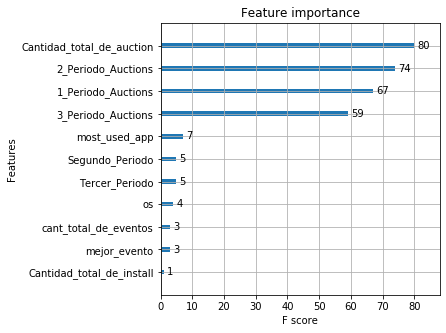

In [376]:
xgb.plot_importance(final_gb)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

In [234]:
#ahora predigo los ids que pide el TP
tesdmat=xgb.DMatrix(X_competition)
y_pred_competition=final_gb.predict(tesdmat)

In [235]:
features.append("device_id")
X_competition = df_competition[features]

In [268]:
prediction_appearances = X_competition[["device_id"]]
prediction_appearances["seconds_until_next_appearance"] = y_pred_competition

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


# Ahora hago la prediccion para tiempo en instalar

In [281]:
ids_to_predict_numbers_convertion = ids_to_predict_numbers_convertion.rename(columns={"ref_hash": "device_id"})

In [282]:
ids_to_predict_numbers_convertion.head()

,device_id,date
0,1000169251625791246,2019-05-27
2,1000395625957344683,2019-05-27
4,1003027494996471685,2019-05-27
6,1006670001679961544,2019-05-27
8,1007573308966476713,2019-05-27


In [283]:
#conversiones de los primeros 3 dias. uso para entrenar
convertions_train = pd.read_csv("auctions_deltas_to_convertion_train.csv",header=None, names=["device_id", "date", "seconds_until_convertion"])

In [284]:
#conversiones de los segunods 3 dias . uso para testear performance
convertions_test = pd.read_csv("auctions_deltas_to_convertion_test.csv",header=None, names=["device_id", "date", "seconds_until_convertion"])

In [285]:
convertions_train.head()

,device_id,date,seconds_until_convertion
0,8323952185725734415,2019-04-20 05:35:45.651502,259200.0
1,8323952185725734415,2019-04-20 05:40:46.744391,259200.0
2,8323952185725734415,2019-04-20 05:48:22.167361,259200.0
3,8323952185725734415,2019-04-20 05:51:43.749231,259200.0
4,8323952185725734415,2019-04-20 05:51:52.533312,259200.0


In [286]:
#agrego mismos features

In [287]:
df_train = convertions_train.merge(most_used_app, on="device_id", how="left")

In [288]:
df_test = convertions_test.merge(most_used_app, on="device_id", how="left")
df_competition = ids_to_predict_numbers_convertion.merge(most_used_app, on="device_id", how="left")

In [289]:
#renombro para dejar mas claro que el nombre del nuevo feature
df_train = df_train.rename({"application_id": "most_used_app"}, axis="columns")
df_test = df_test.rename({"application_id": "most_used_app"}, axis="columns")
df_competition = df_competition.rename({"application_id": "most_used_app"}, axis="columns")

In [290]:
#reemplazo los nan de most used app por un nuemero no existente
df_train["most_used_app"] = df_train["most_used_app"].fillna(-1)
df_test["most_used_app"] = df_test["most_used_app"].fillna(-1)
df_competition["most_used_app"] = df_competition["most_used_app"].fillna(-1)

In [291]:
#lo agrego a DF, siempre left join
df_train = df_train.merge(os,how="left", on="device_id")
df_test = df_test.merge(os,how="left", on="device_id")
df_competition = df_competition.merge(os,how="left", on="device_id")

In [292]:
df_train["os"] = df_train["os"].fillna("other")
df_test["os"] = df_test["os"].fillna("other")
df_competition["os"] = df_competition["os"].fillna("other")

In [293]:
#PRUEBO OTRA VEZ con random forest
#antes tengo que convertir a numeros los campos que son string (en este caso solo OS)
#USO LABEL ENCODER
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [294]:
#encodeo columna os
le.fit(df_train["os"])
df_train["os"] = le.transform(df_train["os"])
df_test["os"] = le.transform(df_test["os"])
df_competition["os"] = le.transform(df_competition["os"])

In [295]:
#lo agrego a DF, siempre left join
df_train = df_train.merge(features_cantidades,how="left", on="device_id")
df_test = df_test.merge(features_cantidades,how="left", on="device_id")
df_competition = df_competition.merge(features_cantidades,how="left", on="device_id")

In [296]:
df_train.fillna(0, inplace = True )
df_test.fillna(0, inplace = True )
df_competition.fillna(0, inplace = True)

In [297]:
df_train.columns

Index(['device_id', 'date', 'seconds_until_convertion', 'most_used_app', 'os',
       'Unnamed: 0_x', '1_Periodo_Installs', '2_Periodo_Installs',
       '3_Periodo_Installs', 'Cantidad_total_de_install', '1_Periodo_Auctions',
       '2_Periodo_Auctions', '3_Periodo_Auctions', 'Cantidad_total_de_auction',
       'Unnamed: 0_y', 'mejor_evento', 'cant_mejor_evento',
       'cant_total_de_eventos', 'Primer_Periodo', 'Segundo_Periodo',
       'Tercer_Periodo'],
      dtype='object')

In [321]:
features = [#"device_id",
       'most_used_app', 'os','cant_total_de_eventos', 'Cantidad_total_de_install', 'Cantidad_total_de_auction', '1_Periodo_Auctions',
       '2_Periodo_Auctions', '3_Periodo_Auctions']

In [322]:

#CREO X_TRAIN Y Y_TRAIN  sin DEVICE ID
X_train = df_train[features]
y_train = df_train['seconds_until_convertion']
X_test = df_test[features]
y_test = df_test['seconds_until_convertion']
X_competition = df_competition[features]

#### Random Forest

In [94]:
RandomForestRegressor()

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators='warn',
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [123]:
regr = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators='warn',
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
#entreno el modeo
regr.fit(X_train, y_train)  
y_pred = regr.predict(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [124]:
#miro error X_test

print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))

Mean squared error: 4648344712.02


In [100]:
#ahora predigo los ids que pide el TP
y_pred_competition = regr.predict(X_competition)

In [103]:
prediction_convertion = X_competition[["device_id"]]
prediction_convertion["seconds_until_convertion"] = y_pred_competition

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## XgBoost

In [323]:
xgdmat=xgb.DMatrix(X_train, y_train)
our_params={'eta':0.1,'seed':0,'subsample':0.8,'colsample_bytree':0.8,'objective':'reg:linear','max_depth':5,'min_child_weight':1, 'n_estimators': 20, "learning_rate": 0.1}
final_gb=xgb.train(our_params,xgdmat)

[00:49:06] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[00:49:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[00:49:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[00:49:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[00:49:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[00:49:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[00:49:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[00:49:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[00:49:30] src/tree/updater_prune.cc:74: tre

In [324]:
tesdmat=xgb.DMatrix(X_test)
y_pred=final_gb.predict(tesdmat)
y_pred

array([148199.69, 148199.69, 148199.69, ..., 167838.42, 166604.81,
       168590.  ], dtype=float32)

In [325]:
from sklearn.metrics import mean_squared_error
import math
testScore=math.sqrt(mean_squared_error(y_test.values,y_pred))
print(testScore)

100264.60325661294


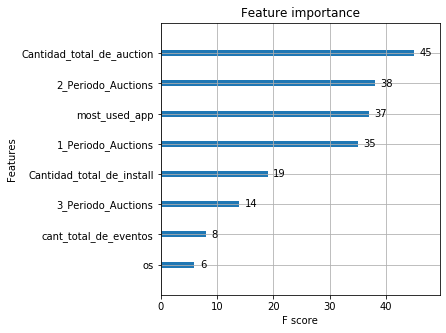

In [326]:
xgb.plot_importance(final_gb)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

In [327]:
#ahora predigo los ids que pide el TP
tesdmat=xgb.DMatrix(X_competition)
y_pred_competition=final_gb.predict(tesdmat)

In [328]:
features.append("device_id")
X_competition = df_competition[features]

In [329]:
prediction_convertion = X_competition[["device_id"]]
prediction_convertion["seconds_until_convertion"] = y_pred_competition

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## Submiteo

In [204]:
#miro como me quedaron los dataframes de predicciones
#para submitear tiene que quedar con el formato que piden. o sea los ids de appearances tienen que 
#terminar en _st y los ids de convertions tienen que terminar en _sc

In [237]:
prediction_appearances.head()

,device_id,seconds_until_convertion
0,1000169251625791246,5699.771973
1,1000395625957344683,4041.256104
2,1003027494996471685,1499.731689
3,1006670001679961544,12395.857422
4,1007573308966476713,10350.041016


In [239]:
prediction_convertion.head()

,device_id,seconds_until_convertion
0,1000169251625791246,147694.343750
1,1000395625957344683,140101.703125
2,1003027494996471685,146973.406250
3,1006670001679961544,140101.703125
4,1007573308966476713,149031.718750


In [240]:
#paso al formato de submit

In [269]:
prediction_appearances = prediction_appearances.rename(columns={"device_id": "ref_hash", "seconds_until_next_appearance": "obj"})

In [307]:
prediction_convertion = prediction_convertion.rename(columns={"device_id": "ref_hash", "seconds_until_convertion": "obj"})

In [271]:
prediction_appearances["ref_hash"] = prediction_appearances["ref_hash"].apply(lambda ref: str(ref)+"_st")

In [308]:
prediction_convertion["ref_hash"] = prediction_convertion["ref_hash"].apply(lambda ref: str(ref)+"_sc")

In [309]:
prediction_appearances.head()

,ref_hash,obj
0,1000169251625791246_st,5699.771973
1,1000395625957344683_st,4041.256104
2,1003027494996471685_st,1499.731689
3,1006670001679961544_st,12395.857422
4,1007573308966476713_st,10350.041016


In [310]:
prediction_convertion.head()

,ref_hash,obj
0,1000169251625791246_sc,147694.343750
1,1000395625957344683_sc,140101.703125
2,1003027494996471685_sc,146973.406250
3,1006670001679961544_sc,140101.703125
4,1007573308966476713_sc,149031.718750


In [311]:
#concateno las predicciones porque tienen que devolverse todas juntas

In [312]:
full_pred = pd.concat([prediction_appearances, prediction_convertion])

In [313]:
#hago un left join con ids to predict para oredenarlos como pide el enunciado

In [314]:
ids_to_predict.head()

,ref_hash
0,1000169251625791246_sc
1,1000169251625791246_st
2,1000395625957344683_sc
3,1000395625957344683_st
4,1003027494996471685_sc


In [315]:
full_pred = ids_to_predict.merge(full_pred, on="ref_hash", how="left")

In [316]:
#ya esta igualito a como pide el enunciado
full_pred

,ref_hash,obj
0,1000169251625791246_sc,147694.343750
1,1000169251625791246_st,5699.771973
2,1000395625957344683_sc,140101.703125
3,1000395625957344683_st,4041.256104
4,1003027494996471685_sc,146973.406250
5,1003027494996471685_st,1499.731689
6,1006670001679961544_sc,140101.703125
7,1006670001679961544_st,12395.857422
8,1007573308966476713_sc,149031.718750
9,1007573308966476713_st,10350.041016


In [317]:
#paso float de obj a int
full_pred["obj"] = full_pred["obj"].astype(np.int64)

In [318]:
full_pred.to_csv("xgboost_pred.csv", index=False)

In [319]:
full_pred.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8074 entries, 0 to 8073
Data columns (total 2 columns):
ref_hash    8074 non-null object
obj         8074 non-null int64
dtypes: int64(1), object(1)
memory usage: 189.2+ KB


In [320]:
pd.read_csv("target_competencia_ids.csv").info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8074 entries, 0 to 8073
Data columns (total 2 columns):
ref_hash    8074 non-null object
obj         8074 non-null int64
dtypes: int64(1), object(1)
memory usage: 126.2+ KB
